In [1]:
import os
import sys
import re
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from itertools import combinations
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from scipy.stats import bootstrap, binom_test, entropy
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean, pdist, squareform
from Bio import SeqIO
import tqdm
from ete3 import PhyloTree

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

from utils import (complete_sbs192_columns, calc_edgewise_spectra, 
                   collapse_sbs192, get_cossim, get_eucdist, calc_phylocoefs)

%matplotlib inline

In [2]:
coda = CodonAnnotation(2)

## Mammals tree

### Filter bad rnd replics

In [3]:
nucls = list('ACGT')

data = []
for p in glob.glob('../data/alisim/generations_mam/*.fa'):
    raw_cond = p.split('/')[-1].split('.fa')[0]
    mdl, _, seq, _, replic = raw_cond.split('_')
    replic = int(replic)
    cond = f'{mdl}-{seq}'
    for rec in SeqIO.parse(p, 'fasta'):
        if rec.id == 'ROOT':
            seq = str(rec.seq)
            break
    data.append([raw_cond, cond, replic, seq])

human_cytb_seq   = set([x[3] for x in data if x[1].endswith('cytb')]).pop()
human_cytb_freqs = dict(Counter(human_cytb_seq))
human_cytb_freqs = [human_cytb_freqs[x]/len(human_cytb_seq) for x in nucls]

data = [x for x in data if x[1].endswith('rnd')]
df = pd.DataFrame(data, columns=['raw_cond', 'cond', 'replic', 'seq'])
df['len'] = df.seq.apply(len)
assert df['len'].nunique() == 1

freqs = pd.DataFrame(list(df.seq.apply(lambda x: dict(Counter(x))).values))
freqs = (freqs.T / freqs.sum(axis=1)).T.fillna(0.)

df = df.merge(freqs, left_index=True, right_index=True)
print(df.shape)
df.head()

(100, 9)


,raw_cond,cond,replic,seq,len,C,T,G,A
0,12.12_mam_rnd_replica_35,12.12-rnd,35,CCTTGGTCACGGTGCTTGGCCCTTTTCATACTGCCTGCGGACAGCA...,1140,0.300000,0.297368,0.270175,0.132456
1,12.12_mam_rnd_replica_15,12.12-rnd,15,GGTTGGTGAATGTGGTTGGCCGTTTTAATAGTGGCTGAGGACATCA...,1140,0.106140,0.307018,0.392105,0.194737
2,gtr_mam_rnd_replica_2,gtr-rnd,2,GGTTGGGGACGGTGGTTGGGGGGTTTCCGAGTGGCTGCGGACAGGA...,1140,0.154386,0.219298,0.502632,0.123684
3,gtr_mam_rnd_replica_28,gtr-rnd,28,CCTTGCGCAAGGTCCTTCCCCCGTTTAAGACTCCATGACCAAAGCA...,1140,0.404386,0.217544,0.148246,0.229825
4,gtr_mam_rnd_replica_16,gtr-rnd,16,CCTGGCGCAAGGTCCTTGCAACGTTTAAGACTGCATGACCAAAGAA...,1140,0.257895,0.200877,0.223684,0.317544


In [53]:
base = 4
human_cytb_entropy = entropy(human_cytb_freqs, base=base)
human_cytb_entropy

0.956904812547667

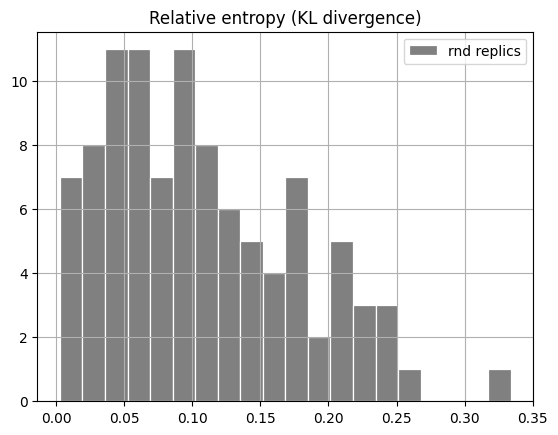

In [54]:
df['entropy'] = df[nucls].apply(partial(entropy, qk=human_cytb_freqs, base=base), axis=1)

df.entropy.hist(bins=20, label='rnd replics', color='grey', lw=0.9, ec="w",)
# plt.vlines(human_cytb_entropy, 0, 10, 'red', 'dashed', label='human cytb')
plt.title('Relative entropy (KL divergence)')
plt.legend()
plt.show()

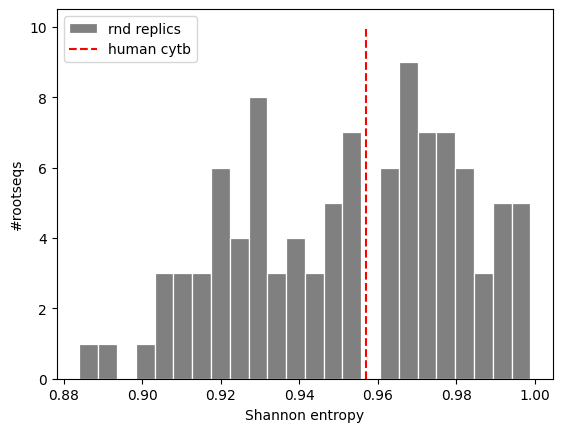

In [55]:
df['entropy'] = df[nucls].apply(partial(entropy, base=base), axis=1)

df.entropy.hist(bins=24, label='rnd replics', color='grey', lw=0.9, ec="w",)
plt.vlines(human_cytb_entropy, 0, 10, 'red', 'dashed', label='human cytb')
plt.legend(loc='upper left')
plt.grid(False)
plt.xlabel('Shannon entropy')
plt.ylabel('#rootseqs')
plt.savefig("../figures/alisim/rnd_replics_rootseq_entropy.pdf")
plt.show()

In [56]:
def find_polyN(seq: str):
    polyA = re.findall('A{6,}', seq)
    polyC = re.findall('C{6,}', seq)
    polyG = re.findall('G{6,}', seq)
    polyT = re.findall('T{6,}', seq)
    polys = polyA + polyC + polyG + polyT
    return polys

find_polyN(human_cytb_seq)

[]

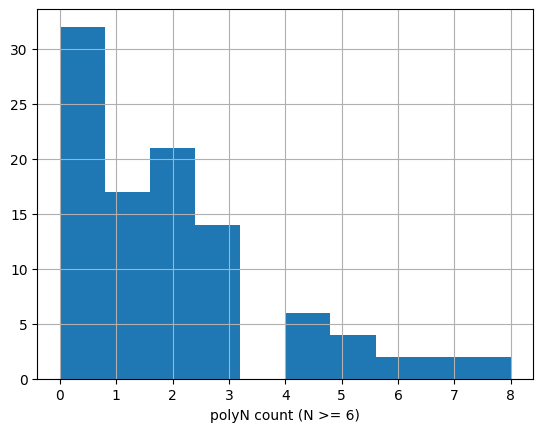

In [57]:
df['polyN_count'] = df.seq.apply(find_polyN).apply(len)

df['polyN_count'].hist()
plt.xlabel('polyN count (N >= 6)');

# check 

In [62]:
df[['entropy','polyN_count']].sort_values('entropy').head(20).T

,27,52,96,31,41,94,36,22,19,28,90,55,44,89,67,57,74,53,69,47
entropy,0.883974,0.891861,0.902306,0.903413,0.904369,0.906967,0.909325,0.911968,0.912582,0.916084,0.91702,0.917347,0.917643,0.919351,0.919916,0.920719,0.920726,0.920808,0.922448,0.922618
polyN_count,8.000000,7.000000,3.000000,3.000000,0.000000,7.000000,3.000000,3.000000,2.000000,3.000000,8.00000,1.000000,2.000000,0.000000,4.000000,1.000000,5.000000,5.000000,1.000000,3.000000


In [60]:
rnd_samples = df[df.entropy >= 0.9].raw_cond.values
len(rnd_samples)

98

### Load and Preprocess data

In [4]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaMut", "ProbaFull", "RefNode", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "RefNode", "AltNode"]
cols_rec_exp = ["Mut", "Label", "Pos", "Proba", "Node"]
cols_gt_exp  = ["Mut", "Label", "Pos",  "Node"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def read_mam_spectra(cond):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"
    path_to_tree = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/iqtree_anc_tree.nwk"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_rec_exp = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/expected_mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"
    path_to_gt_exp  = f"../data/alisim/spectra_groundtruth_mam/{cond}/expected_mutations.tsv"

    existance = [os.path.exists(x) for x in [path_to_rates, path_to_mapping, path_to_tree, 
                                             path_to_rec_exp, path_to_rec_obs, path_to_gt_obs, path_to_gt_exp]]
    if all(existance):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        rec_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=cols_rec_exp)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        gt_exp  = pd.read_csv(path_to_gt_exp,  sep="\t", usecols=cols_gt_exp)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        rec_exp = rec_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)
        gt_obs  = gt_obs.merge(rates[["Site", "Cat"]],  left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        gt_exp  = gt_exp.merge(rates[["Site", "Cat"]],  left_on="Pos", right_on="Site").drop("Pos", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        # fix ProbaFull in obs and Proba in exp
        tree = PhyloTree(path_to_tree, format=1)
        phylocoefs = calc_phylocoefs(tree)
        rec_obs['ProbaFull'] = rec_obs['ProbaMut'] * rec_obs['RefNode'].map(phylocoefs) * rec_obs['AltNode'].map(phylocoefs)

        rec_obs['RefPhylocoef'] = rec_obs['ProbaFull'] / rec_obs['ProbaMut']
        n2phylocoef_old = rec_obs.groupby('RefNode')['RefPhylocoef'].mean().to_dict()
        rec_exp['Proba'] = rec_exp.Proba / rec_exp.Node.map(n2phylocoef_old) * rec_exp['Node'].map(phylocoefs)
        
        return rec_obs, rec_exp, gt_obs, gt_exp


def compare_mam_spectra(
        data, pcutoff=0.3, categories=[4, 5, 6], nmtypes_cutoff=10, nobs_cuttof=10, 
        metric_func=get_cossim, only_spectra_gt=False, cond=None,
    ):
    if data is None:
        return 'no data'
    elif isinstance(data, str):
        cond = data
        x = read_mam_spectra(cond)
        if x is None:
            return 'no data'
        rec_obs, rec_exp, gt_obs, gt_exp = x
    elif len(data) == 4:
        rec_obs, rec_exp, gt_obs, gt_exp = data
    else:
        raise Exception("'data' input must be either list of dataframes or str with 'cond' label")


    cat_lbl = 'cat' + ''.join(str(x) for x in categories)
    metric_name = metric_func.__name__.split("_")[-1]

    #first of all gt, and then rec
    #prepare OBS gt
    gt_obs_all  = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat.isin(categories))].assign(ProbaFull=1.0)
    gt_obs_syn  = gt_obs_all[(gt_obs_all.Label >= 1)]
    #prepare EXP gt
    gt_exp  = gt_exp[(gt_exp.Cat.isin(categories))].assign(Proba=1.0)
    gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all")]
    gt_exp_syn = gt_exp[(gt_exp.Label.astype("category") == "syn")]
    #calc tree spectra gt
    gt_all_spectra12, gt_all_spectra192 = calc_edgewise_spectra(gt_obs_all, gt_exp_all, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
    gt_syn_spectra12, gt_syn_spectra192 = calc_edgewise_spectra(gt_obs_syn, gt_exp_syn, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
    
    if only_spectra_gt:
        return (
            pd.concat([
                gt_all_spectra12.assign(MutType="all", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                gt_syn_spectra12.assign(MutType="syn", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
            ]),
            pd.concat([
                gt_all_spectra192.assign(MutType="all", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                gt_syn_spectra192.assign(MutType="syn", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
            ]),
        )
    
    #prepare OBS rec
    rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat.isin(categories))]
    rec_obs_syn = rec_obs_all[(rec_obs_all.Label >= 1)]
    #prepare EXP rec
    rec_exp = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Cat.isin(categories))]
    rec_exp_all = rec_exp[(rec_exp.Label.astype("category") == "all")]
    rec_exp_syn = rec_exp[(rec_exp.Label.astype("category") == "syn")]

    #calc tree spectra rec
    rec_all_spectra12, rec_all_spectra192 = calc_edgewise_spectra(rec_obs_all, rec_exp_all, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
    rec_syn_spectra12, rec_syn_spectra192 = calc_edgewise_spectra(rec_obs_syn, rec_exp_syn, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
    
    #compare trees edge-wise using metric
    metric12_all  = metric_func(gt_all_spectra12,  rec_all_spectra12).rename(metric_name  + "12_all").reset_index()
    metric192_all = metric_func(gt_all_spectra192, rec_all_spectra192).rename(metric_name + "192_all").reset_index()
    metric12_syn  = metric_func(gt_syn_spectra12,  rec_syn_spectra12).rename(metric_name  + "12_syn").reset_index()
    metric192_syn = metric_func(gt_syn_spectra192, rec_syn_spectra192).rename(metric_name + "192_syn").reset_index()

    if len(metric12_all) == 0 or len(metric12_syn) == 0:
        return 0
    
    total_metric = metric12_all.merge(metric12_syn, "outer", on=["RefNode", "AltNode"])

    if len(metric192_all):
        total_metric = total_metric.merge(metric192_all, "outer", on=["RefNode", "AltNode"])
    if len(metric192_syn):
        total_metric = total_metric.merge(metric192_syn, "outer", on=["RefNode", "AltNode"])
    
    return total_metric.assign(Cond=cond, Cat=cat_lbl)


# compare_mam_spectra('gtr_mam_rnd_replica_4', categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist)

In [5]:
samples = [d.split("/")[-1] for d in glob.glob("../data/alisim/spectra_reconstructed_mam/*")]

# rnd_samples = ['12.12_mam_rnd_replica_26', 'gtr_mam_rnd_replica_46',
#        '12.12_mam_rnd_replica_35', 'gtr_mam_rnd_replica_37',
#        '12.12_mam_rnd_replica_13', 'gtr_mam_rnd_replica_11',
#        '12.12_mam_rnd_replica_41', '12.12_mam_rnd_replica_28',
#        '12.12_mam_rnd_replica_36', '12.12_mam_rnd_replica_47',
#        'gtr_mam_rnd_replica_13', '12.12_mam_rnd_replica_45',
#        'gtr_mam_rnd_replica_38', 'gtr_mam_rnd_replica_34',
#        'gtr_mam_rnd_replica_12', 'gtr_mam_rnd_replica_43',
#        '12.12_mam_rnd_replica_3', 'gtr_mam_rnd_replica_8',raw_data123
#        '12.12_mam_rnd_replica_1', '12.12_mam_rnd_replica_23',
#        'gtr_mam_rnd_replica_5', 'gtr_mam_rnd_replica_15',
#        'gtr_mam_rnd_replica_49', 'gtr_mam_rnd_replica_44',
#        'gtr_mam_rnd_replica_39', 'gtr_mam_rnd_replica_40',
#        '12.12_mam_rnd_replica_9', '12.12_mam_rnd_replica_44',
#        'gtr_mam_rnd_replica_47', 'gtr_mam_rnd_replica_48',
#        '12.12_mam_rnd_replica_7', '12.12_mam_rnd_replica_6',
#        'gtr_mam_rnd_replica_30', '12.12_mam_rnd_replica_49',
#        '12.12_mam_rnd_replica_27', 'gtr_mam_rnd_replica_4',
#        '12.12_mam_rnd_replica_38', 'gtr_mam_rnd_replica_41',
#        '12.12_mam_rnd_replica_34']

# samples_filtered = [x for x in samples if 'cytb' in x] + rnd_samples
# samples = samples_filtered
len(samples)

200

### Check func

In [6]:
one = compare_mam_spectra(samples[0], 0.3, [4,5,6], 5, 5)
print(samples[:5])
one

['12.12_mam_cytb_replica_31', '12.12_mam_cytb_replica_15', 'gtr_mam_rnd_replica_28', '12.12_mam_cytb_replica_43', 'gtr_mam_rnd_replica_25']


,RefNode,AltNode,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn,Cond,Cat
0,Node10,Node11,0.960978,NaN,0.529236,NaN,12.12_mam_cytb_replica_31,cat456
1,Node10,Node40,0.864034,0.773998,0.410554,0.148192,12.12_mam_cytb_replica_31,cat456
2,Node100,Node101,0.872450,NaN,0.690176,NaN,12.12_mam_cytb_replica_31,cat456
3,Node100,RN_94,0.995418,0.985730,0.975041,0.984946,12.12_mam_cytb_replica_31,cat456
4,Node1000,Node1002,0.999998,NaN,0.999994,NaN,12.12_mam_cytb_replica_31,cat456
...,...,...,...,...,...,...,...,...
7234,Node994,Node995,0.999813,NaN,0.999913,NaN,12.12_mam_cytb_replica_31,cat456
7235,Node994,RN_987,1.000000,0.999999,0.999999,1.000000,12.12_mam_cytb_replica_31,cat456
7236,Node995,Node996,0.999956,NaN,0.999918,NaN,12.12_mam_cytb_replica_31,cat456
7237,Node996,Node997,0.999820,NaN,0.999908,NaN,12.12_mam_cytb_replica_31,cat456


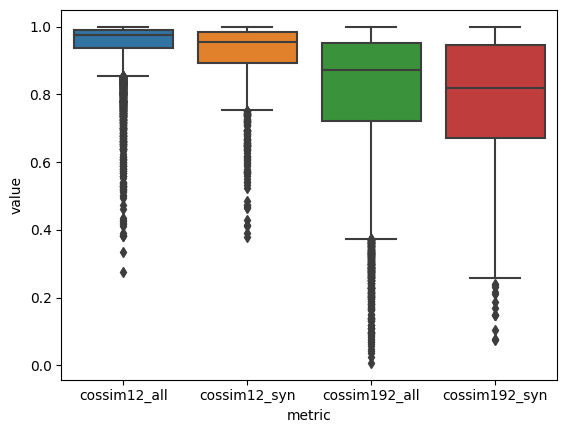

In [32]:
sns.boxplot(
    data=one.melt(
        ["RefNode", "AltNode"], 
        ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
        "metric"), 
    x="metric", y="value");

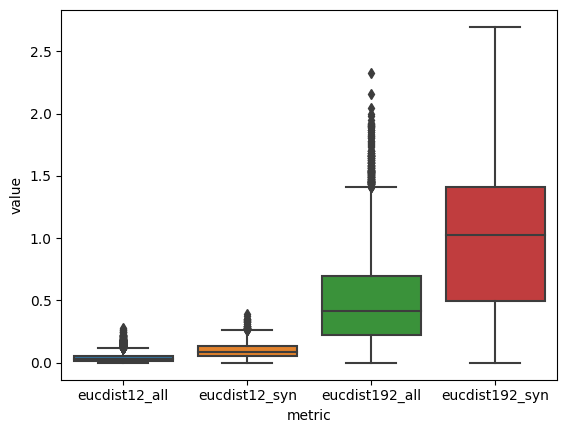

In [33]:
two = compare_mam_spectra(samples[0], 0.3, [4,5,6], 5, 5, get_eucdist)

sns.boxplot(
    data=two.melt(
        ["RefNode", "AltNode"], 
        ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
        "metric"), 
    x="metric", y="value");

In [18]:
three = compare_mam_spectra(samples[0], 0.3, [1,2,3,4,5,6], 5, 5, get_eucdist, only_spectra_gt=True)

In [23]:
three[1].head()

Mut                                                 A[A>C]A  A[A>C]C  \
Cond                    MutType RefNode  AltNode                       
gtr_mam_cytb_replica_18 all     Node10   Node11    0.066667     0.12   
                                         Node40    0.100000     0.12   
                                Node100  Node101   0.041667     0.00   
                                         RN_94     0.083333     0.00   
                                Node1000 Node1001  0.000000     0.00   

Mut                                                 A[A>C]G   A[A>C]T  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.066667  0.034483   
                                         Node40    0.066667  0.206897   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.045455  0.000000   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                C[A>C]A   C[A>C]C  C[A>C]G  \
Cond                    MutType RefNode  AltNode                                
gtr_mam_cytb_replica_18 all     Node10   Node11       0.08  0.148148    0.125   
                                         Node40       0.08  0.000000    0.000   
                                Node100  Node101      0.04  0.034483    0.000   
                                         RN_94        0.08  0.000000    0.000   
                                Node1000 Node1001     0.00  0.000000    0.000   

Mut                                                 C[A>C]T   G[A>C]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.105263  0.166667   
                                         Node40    0.000000  0.000000   
                                Node100  Node101   0.055556  0.000000   
                                         RN_94     0.111111  0.000000   
                                Node1000 Node1001  0.000000  0.047619   

Mut                                                 G[A>C]C  ...   C[T>G]G  \
Cond                    MutType RefNode  AltNode             ...             
gtr_mam_cytb_replica_18 all     Node10   Node11    0.052632  ...  0.000000   
                                         Node40    0.052632  ...  0.000000   
                                Node100  Node101   0.000000  ...  0.000000   
                                         RN_94     0.000000  ...  0.055556   
                                Node1000 Node1001  0.000000  ...  0.000000   

Mut                                                 C[T>G]T   G[T>G]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.000000  0.000000   
                                         Node40    0.050000  0.000000   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.041667  0.058824   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                 G[T>G]C   G[T>G]G  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.100000  0.142857   
                                         Node40    0.000000  0.000000   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.083333  0.000000   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                 G[T>G]T   T[T>G]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.000000  0.045455   
                                         Node40    0.000000  0.000000   
                                Node100 

### Check number of used edges

In [23]:
rec_obs, rec_exp, gt_obs, gt_exp = read_mam_spectra(samples[0])

In [47]:
a = (rec_obs.groupby(['AltNode', 'Cat']).ProbaFull.sum().unstack().fillna(0.) > 5).sum(axis=0).rename('num_of_edges_for_analysis').reset_index()
b = (gt_obs.groupby(['AltNode', 'Cat']).Mut.count().unstack() > 5).sum(axis=0).rename('num_of_edges_for_analysis').reset_index()

pd.concat([a.assign(set='rec'), b.assign(set='gt')])

,Cat,num_of_edges_for_analysis,set
0,1,183,rec
1,2,1679,rec
2,3,3030,rec
3,4,4122,rec
4,5,5642,rec
5,6,6242,rec
0,1,157,gt
1,2,1558,gt
2,3,2811,gt
3,4,3791,gt


In [54]:
def calc_used_edges_cnt(df, nmut_cutoff=5):
    gr = df.groupby(['AltNode', 'Cat'])
    if 'ProbaFull' in df.columns:
        x = (gr.ProbaFull.sum().unstack() >= nmut_cutoff)
    else:
        x = (gr.Mut.count().unstack() >= nmut_cutoff)
    return x.sum(axis=0).rename('used_edges_cnt').reset_index()


def _run_calc_used_edges_paprallel(cond):
    _ = read_mam_spectra(cond)
    if _ is None:
        return None
    rec_obs, _, gt_obs, _ = _
    
    return pd.concat([
        calc_used_edges_cnt(rec_obs).assign(set='rec'), 
        calc_used_edges_cnt(gt_obs).assign(set='gt')
    ])

In [56]:
p = Pool(128)
check_spectra = p.map(_run_calc_used_edges_paprallel, samples)

In [63]:
_data = []
for df,s in zip(check_spectra, samples):
    if df is not None:
        _data.append(df.assign(cond=s))
    else:
        print('missing:', s)
used_edges_cnt = pd.concat(_data, ignore_index=True)
used_edges_cnt['mdl'] = used_edges_cnt.cond.apply(lambda x: x.split('_')[0])
used_edges_cnt['seq'] = used_edges_cnt.cond.apply(lambda x: x.split('_')[2])

missing: gtr_mam_cytb_replica_40


In [64]:
used_edges_cnt

,Cat,used_edges_cnt,set,cond,mdl,seq
0,1,183,rec,gtr_mam_cytb_replica_18,gtr,cytb
1,2,1679,rec,gtr_mam_cytb_replica_18,gtr,cytb
2,3,3030,rec,gtr_mam_cytb_replica_18,gtr,cytb
3,4,4122,rec,gtr_mam_cytb_replica_18,gtr,cytb
4,5,5642,rec,gtr_mam_cytb_replica_18,gtr,cytb
...,...,...,...,...,...,...
2383,2,1026,gt,12.12_mam_rnd_replica_43,12.12,rnd
2384,3,2058,gt,12.12_mam_rnd_replica_43,12.12,rnd
2385,4,3804,gt,12.12_mam_rnd_replica_43,12.12,rnd
2386,5,5408,gt,12.12_mam_rnd_replica_43,12.12,rnd


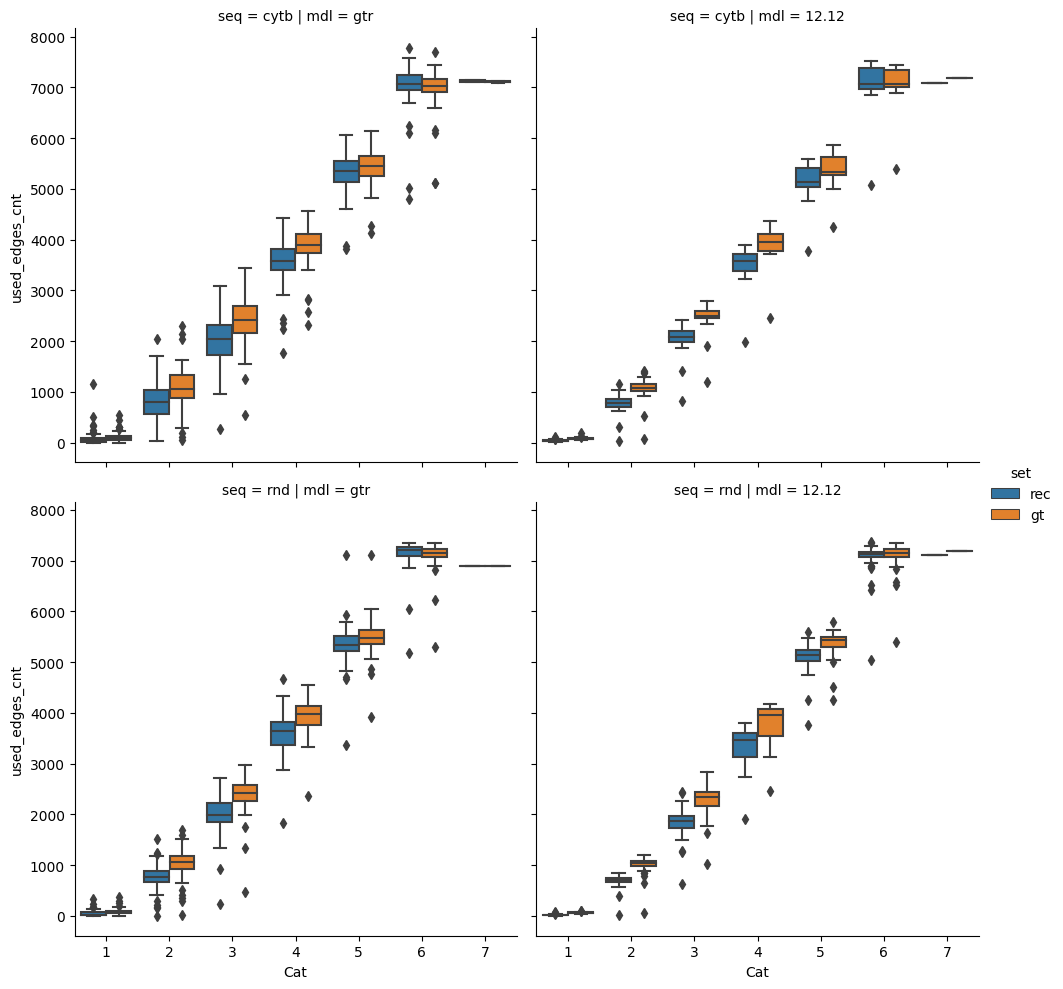

In [66]:
sns.catplot(data=used_edges_cnt, x='Cat', y='used_edges_cnt', hue='set', col='mdl', row='seq', kind='box')

### Slightly explore data

In [5]:
samples[0]

'gtr_mam_cytb_replica_18'

In [12]:
rec_obs, rec_exp, gt_obs, gt_exp = read_mam_spectra(samples[0])

In [13]:
rec_obs.head()

,Mut,Label,ProbaMut,ProbaFull,RefNode,AltNode,Site,Cat,ProbaFull2,RefPhylocoef
0,A[A>C]C,0,0.201179,0.112967,Node4705,Node2,5,1,0.041464,0.561525
1,A[C>A]C,0,0.277872,0.156031,Node4705,Node4,5,1,0.031611,0.561521
2,A[A>C]C,0,0.101895,0.083365,Node2,Node3,5,1,0.067227,0.818149
3,A[A>C]C,0,0.163993,0.134170,Node2,RN_4,5,1,0.115827,0.818145
4,A[C>A]C,0,0.131527,0.081838,Node4,Node5,5,1,0.039122,0.622214


In [28]:
rec_exp.isna().sum(0)

Mut           0
Label         0
Proba         0
Node          0
Site          0
Cat           0
Proba2    98937
dtype: int64

In [73]:
rec_obs[rec_obs.ProbaFull > 0.3].groupby(["Cat", "AltNode"]).ProbaFull.sum().mean(level=0)#.hist(bins=50)

Cat
1    1.812636
2    3.285983
3    4.415482
4    5.436690
5    7.287127
6    7.081877
Name: ProbaFull, dtype: float64

In [74]:
# TODO calculate IoU for each
a = gt_obs[(gt_obs.AltNode == "Node801") & (gt_obs.Label >= 0)]
b = rec_obs[(rec_obs.AltNode == "Node801") & (rec_obs.Label >= 0) & (rec_obs.ProbaFull > 0.3)]

c = pd.merge(a, b, "outer", on=['Mut', 'Label', 'Site'])
c

,Mut,Label,RefNode_x,AltNode_x,Site,Cat_x,ProbaFull,RefNode_y,AltNode_y,Cat_y
0,G[C>A]T,2,Node747,Node801,501,4.0,0.744982,Node747,Node801,4.0
1,A[G>T]C,0,Node747,Node801,635,5.0,0.941088,Node747,Node801,5.0
2,A[C>A]T,0,Node747,Node801,1112,5.0,NaN,NaN,NaN,NaN
3,A[C>A]C,0,Node747,Node801,126,6.0,0.912476,Node747,Node801,6.0
4,G[A>G]C,0,Node747,Node801,317,2.0,0.955379,Node747,Node801,2.0
5,T[G>C]T,0,Node747,Node801,552,6.0,0.841552,Node747,Node801,6.0
6,C[A>C]C,0,Node747,Node801,829,6.0,0.906378,Node747,Node801,6.0
7,C[A>C]C,0,Node747,Node801,5,1.0,0.936491,Node747,Node801,1.0
8,T[T>G]T,0,Node747,Node801,308,5.0,0.955369,Node747,Node801,5.0
9,A[G>A]A,0,Node747,Node801,340,5.0,0.934109,Node747,Node801,5.0


<AxesSubplot:>

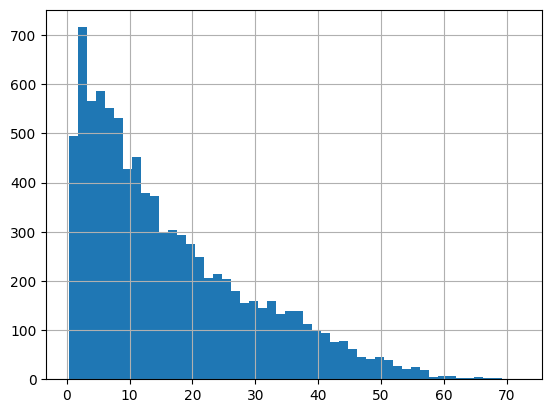

In [10]:
rec_obs[(rec_obs.ProbaFull > 0.3) & (rec_obs.Label >= 0) & (rec_obs.Cat >= 4)].groupby("AltNode").ProbaFull.sum().hist(bins=50)

<AxesSubplot:>

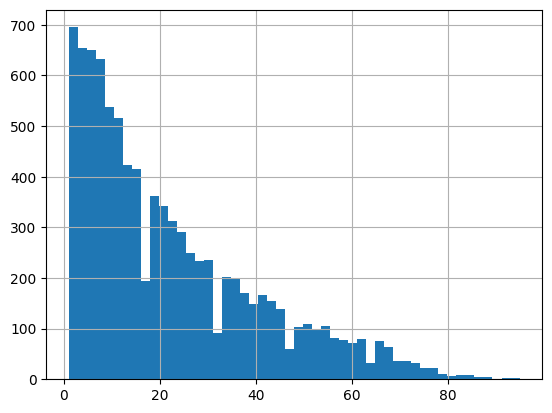

In [49]:
gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= 4)].groupby("AltNode").Mut.count().hist(bins=50)

#### OBS and EXP cossims

In [50]:
pcutoff = 0.3
cat_cutoff = 4

#prepare OBS
rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

#prepare EXP
rec_exp_all = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "all") & (rec_exp.Cat >= cat_cutoff)]
gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all") & (gt_exp.Cat >= cat_cutoff)].assign(Proba=1.0)

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp')

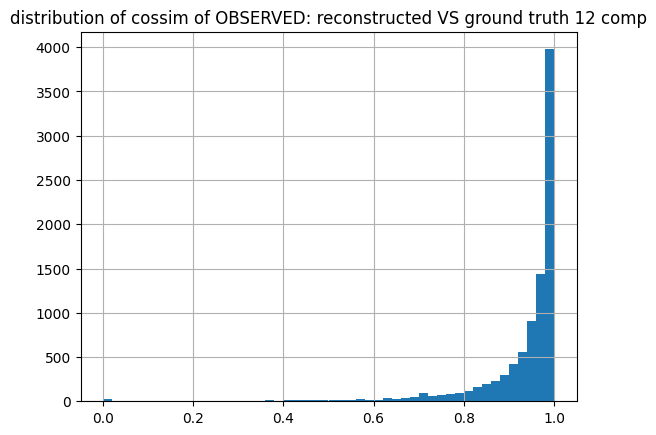

In [51]:
get_cossim(
    collapse_sbs192(rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp')

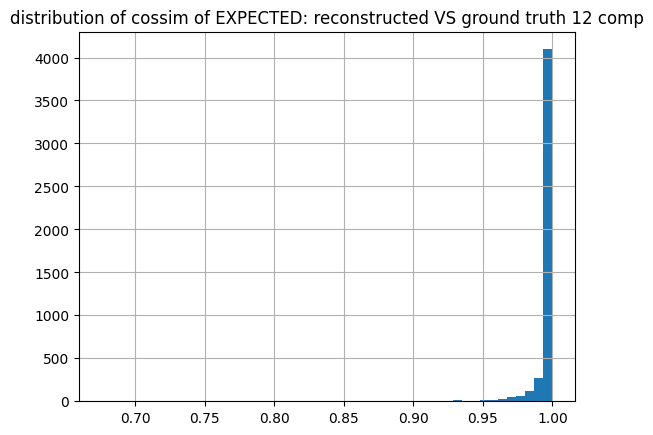

In [52]:
get_cossim(
    collapse_sbs192(rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp')

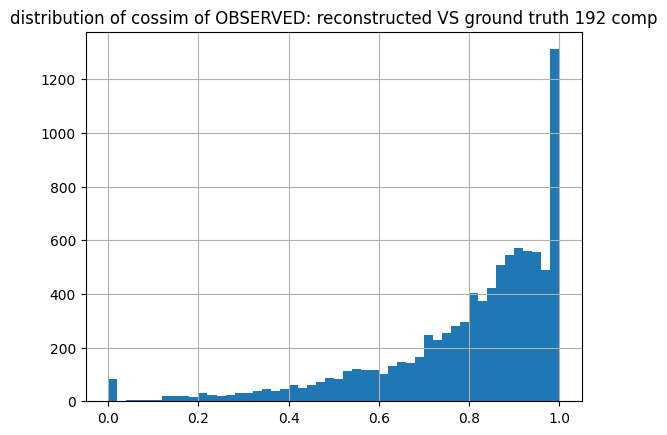

In [53]:
get_cossim(
    rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
    gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp')

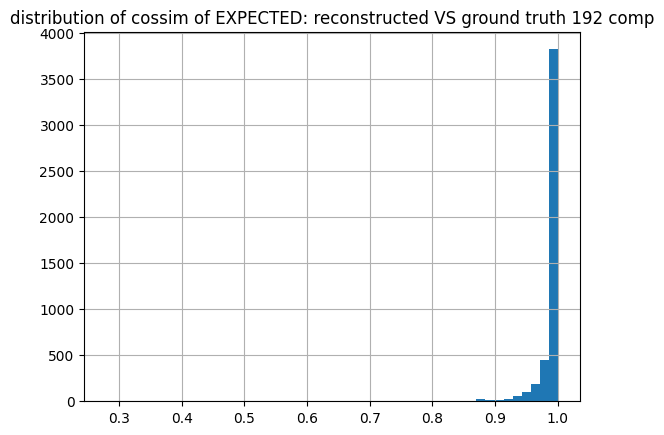

In [54]:
get_cossim(
    rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
    gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp")

OBS mutations were reconstructed with a lot of errors

### Compute cossim: grund truth (simulated) versus reconstructed

In [7]:
p = Pool(64)

In [ ]:
raw_data456 = p.map(
    partial(compare_mam_spectra, categories=[4,5,6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [ ]:
raw_data123 = p.map(
    partial(compare_mam_spectra, categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [ ]:
raw_data4 = p.map(
    partial(compare_mam_spectra, categories=[4], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [ ]:
raw_data5 = p.map(
    partial(compare_mam_spectra, categories=[5], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [ ]:
raw_data6 = p.map(
    partial(compare_mam_spectra, categories=[6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [ ]:
sum([isinstance(x, pd.DataFrame) for x in raw_data123])
# one replica has some reconstruction error

199

In [ ]:
cossim456 = pd.concat(raw_data456).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim456["replica"] = cossim456.Cond.apply(lambda x: x.split("_")[4])
cossim456["cond"]    = cossim456.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim456, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat456.png")

In [ ]:
cossim6 = pd.concat(raw_data6).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim6["replica"] = cossim6.Cond.apply(lambda x: x.split("_")[4])
cossim6["cond"] = cossim6.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim6, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat6.png")

In [ ]:
cossim5 = pd.concat(raw_data5).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim5["replica"] = cossim5.Cond.apply(lambda x: x.split("_")[4])
cossim5["cond"] = cossim5.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim5, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat5.png")

In [ ]:
cossim4 = pd.concat(raw_data4).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim4["replica"] = cossim4.Cond.apply(lambda x: x.split("_")[4])
cossim4["cond"] = cossim4.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim4, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat4.png")

In [ ]:
cossim123 = pd.concat(raw_data123).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim123["replica"] = cossim123.Cond.apply(lambda x: x.split("_")[4])
cossim123["cond"] = cossim123.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim123, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat123.png")

In [ ]:
cossim = pd.concat(raw_data123 + raw_data4 + raw_data5 + raw_data6).melt(
    ["Cond", "Cat", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim["replica"] = cossim.Cond.apply(lambda x: x.split("_")[4])
cossim["cond"] = cossim.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
cossim.head()

,Cond,Cat,RefNode,AltNode,metrica,value,replica,cond
0,gtr_mam_cytb_replica_18,cat123,Node10,Node11,cossim12_all,0.964086,18,gtr-cytb
1,gtr_mam_cytb_replica_18,cat123,Node10,Node40,cossim12_all,0.893056,18,gtr-cytb
2,gtr_mam_cytb_replica_18,cat123,Node100,RN_94,cossim12_all,0.991303,18,gtr-cytb
3,gtr_mam_cytb_replica_18,cat123,Node1003,RN_990,cossim12_all,0.998004,18,gtr-cytb
4,gtr_mam_cytb_replica_18,cat123,Node1004,RN_988,cossim12_all,0.999992,18,gtr-cytb


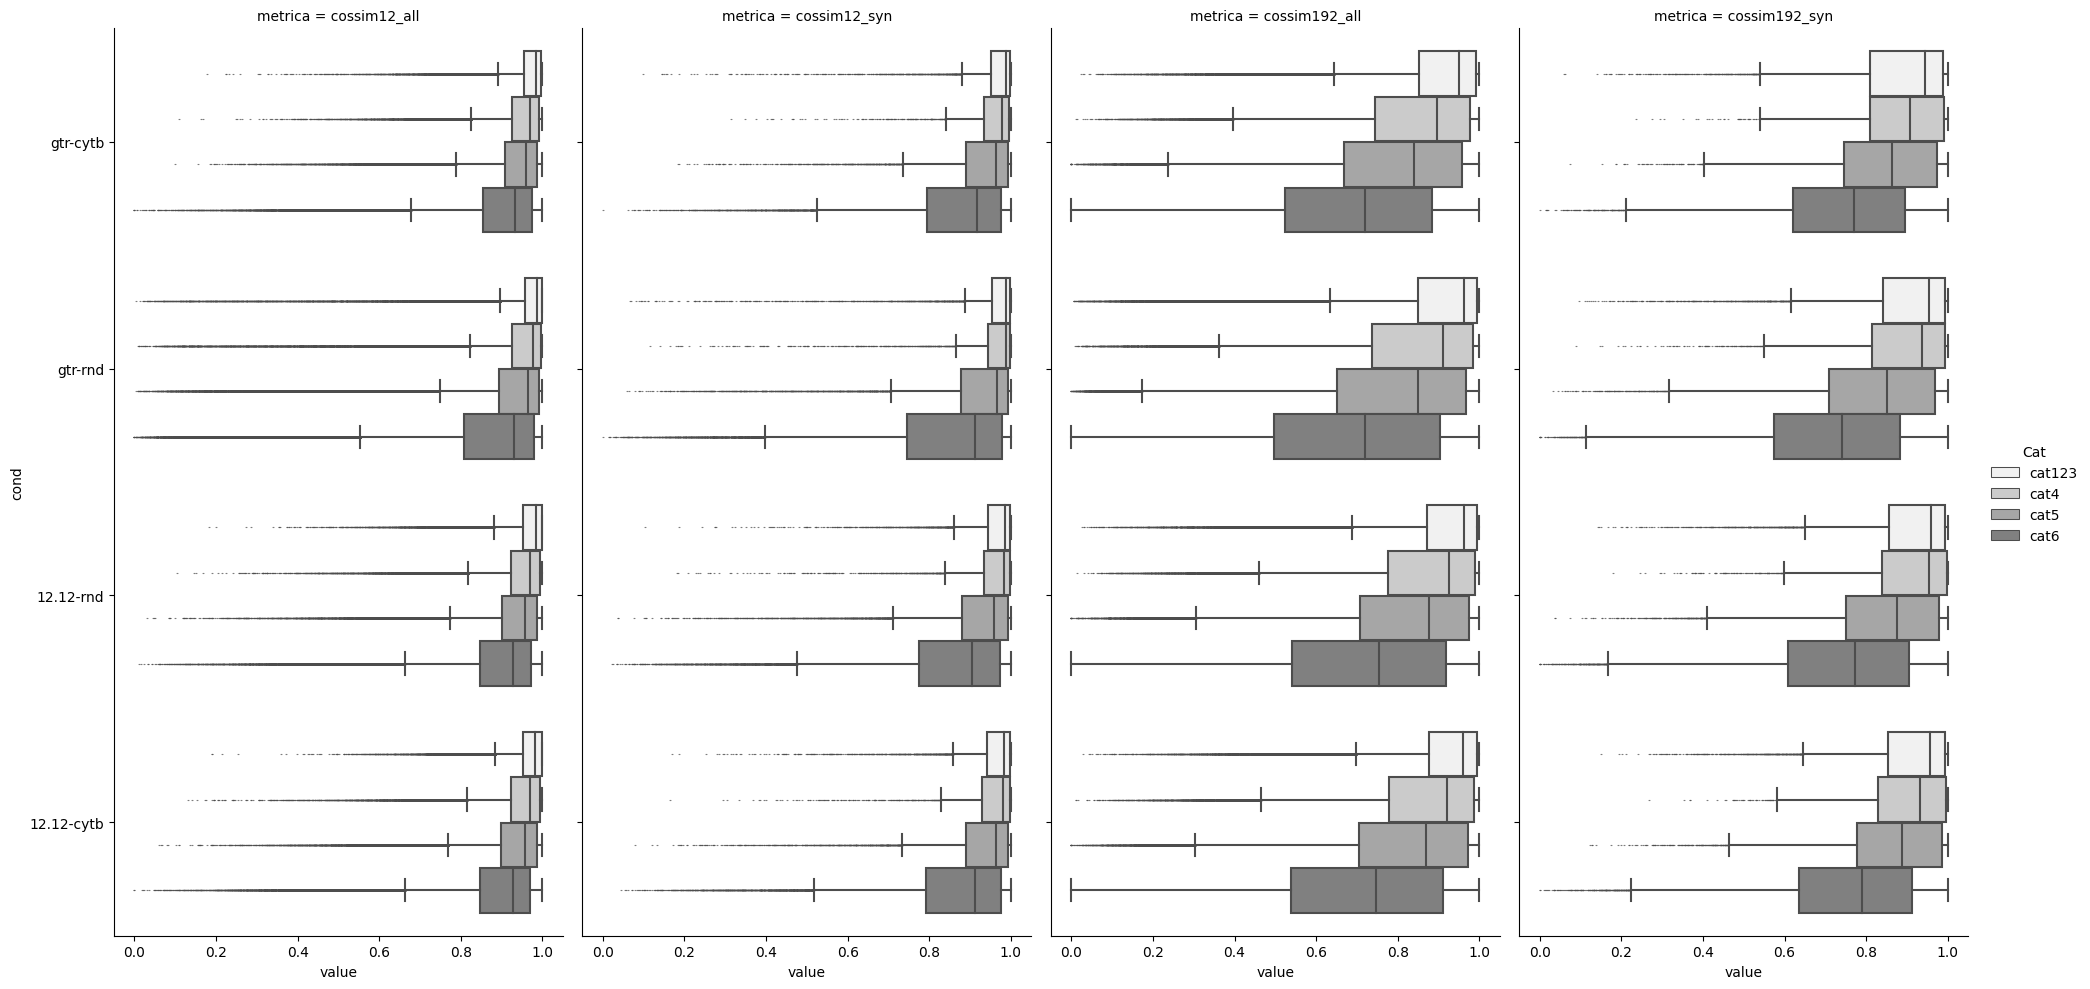

In [55]:
g = sns.catplot(
    data=cossim, x="value", hue="Cat", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=True, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_full.png")

In [ ]:
# MEDIAN
cossim.groupby(["cond", "Cat", "metric"]).value.mean().unstack().round(2)

metrica            cossim12_all  cossim12_syn  cossim192_all  cossim192_syn
cond       Cat                                                             
12.12-cytb cat123          0.96          0.95           0.91           0.90
           cat4            0.94          0.94           0.86           0.89
           cat5            0.93          0.92           0.81           0.86
           cat6            0.89          0.86           0.70           0.76
12.12-rnd  cat123          0.96          0.95           0.90           0.90
           cat4            0.94          0.94           0.86           0.90
           cat5            0.93          0.91           0.81           0.84
           cat6            0.89          0.84           0.70           0.74
gtr-cytb   cat123          0.96          0.95           0.89           0.88
           cat4            0.95          0.95           0.84           0.88
           cat5            0.93          0.92           0.79           0.84
           cat6            0.89          0.86           0.68           0.75
gtr-rnd    cat123          0.96          0.95           0.88           0.89
           cat4            0.93          0.94           0.83           0.88
           cat5            0.91          0.90           0.78           0.81
           cat6            0.85          0.83           0.68           0.71

In [74]:
cossim.groupby(["cond", "metric", "Cat"]).value.describe()\
    .rename_axis(index={"cond": "condition", "Cat": "category"})\
        .to_csv("../data/share/alisim_cossim_mam.csv", float_format="%g")

### Compute eucdist: grund truth (simulated) versus reconstructed

In [9]:
p = Pool(128)

In [16]:
# raw_data456 = p.map(
#     partial(compare_mam_spectra, categories=[4,5,6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
#     samples,
# )

In [10]:
# 3min on 128 threads
raw_data123 = p.map(
    partial(compare_mam_spectra, categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)
Counter([type(x) for x in raw_data123]) # one replica has some reconstruction error

Counter({pandas.core.frame.DataFrame: 197, int: 2, str: 1})

In [11]:
raw_data4 = p.map(
    partial(compare_mam_spectra, categories=[4], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)
Counter([type(x) for x in raw_data4])

Counter({pandas.core.frame.DataFrame: 198, int: 1, str: 1})

In [12]:
raw_data5 = p.map(
    partial(compare_mam_spectra, categories=[5], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)
Counter([type(x) for x in raw_data5])

Counter({pandas.core.frame.DataFrame: 199, str: 1})

In [13]:
raw_data6 = p.map(
    partial(compare_mam_spectra, categories=[6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)
Counter([type(x) for x in raw_data6])

Counter({pandas.core.frame.DataFrame: 199, str: 1})

In [14]:
raw_spectra = p.map(
    partial(compare_mam_spectra, categories=[1,2,3,4,5,6], 
            nmtypes_cutoff=5, nobs_cuttof=5, only_spectra_gt=True), 
    samples,
)
replics_spectra12  = pd.concat([x[0] for x in raw_spectra if isinstance(x, tuple)]).astype(np.float32)
replics_spectra192 = pd.concat([x[1] for x in raw_spectra if isinstance(x, tuple)]).astype(np.float32)
del raw_spectra

In [15]:
data = []
i = 0
for mut_type in ["all", "syn"]:
    for cond1, cond2 in combinations(replics_spectra12.index.get_level_values(0).unique(),2):
        if cond1[:15] == cond2[:15]:
            i += 1
            _c = cond1.split("_")
            cond = _c[0] + "-" + _c[2]
            metric12 = get_eucdist(
                replics_spectra12.loc[cond1, mut_type], 
                replics_spectra12.loc[cond2, mut_type]
            )
            metric192 = get_eucdist(
                replics_spectra192.loc[cond1, mut_type], 
                replics_spectra192.loc[cond2, mut_type]
            )
            data.append(
                metric12.rename("value").reset_index()\
                    .assign(RawCond1=cond1, RawCond2=cond2, 
                            cond=cond, metric=f"eucdist12_{mut_type}")
            )
            data.append(
                metric192.rename("value").reset_index()\
                    .assign(RawCond1=cond1, RawCond2=cond2, 
                            cond=cond, metric=f"eucdist192_{mut_type}")
            )
            if i % 2000 == 0:
                print(i)
print(i)

2000
4000
6000
8000
9702


In [16]:
replic_vs_replic = pd.concat(data).assign(Cat="Replics")

In [17]:
replic_vs_replic.head()

,RefNode,AltNode,value,RawCond1,RawCond2,cond,metric,Cat
0,Node10,Node11,0.098055,12.12_mam_cytb_replica_31,12.12_mam_cytb_replica_15,12.12-cytb,eucdist12_all,Replics
1,Node10,Node40,0.119596,12.12_mam_cytb_replica_31,12.12_mam_cytb_replica_15,12.12-cytb,eucdist12_all,Replics
2,Node100,Node101,0.045019,12.12_mam_cytb_replica_31,12.12_mam_cytb_replica_15,12.12-cytb,eucdist12_all,Replics
3,Node100,RN_94,0.118228,12.12_mam_cytb_replica_31,12.12_mam_cytb_replica_15,12.12-cytb,eucdist12_all,Replics
4,Node1000,Node1001,0.028256,12.12_mam_cytb_replica_31,12.12_mam_cytb_replica_15,12.12-cytb,eucdist12_all,Replics


#### Plot eucdist distributions

##### Detailed

In [ ]:
cossim456 = pd.concat(raw_data456).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim456["replica"] = cossim456.Cond.apply(lambda x: x.split("_")[4])
cossim456["cond"]    = cossim456.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim456, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat456.png")
plt.close()

In [ ]:
cossim6 = pd.concat(raw_data6).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim6["replica"] = cossim6.Cond.apply(lambda x: x.split("_")[4])
cossim6["cond"] = cossim6.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim6, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat6.png")
plt.close()

In [ ]:
cossim5 = pd.concat(raw_data5).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim5["replica"] = cossim5.Cond.apply(lambda x: x.split("_")[4])
cossim5["cond"] = cossim5.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim5, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat5.png")
plt.close()

In [ ]:
cossim4 = pd.concat(raw_data4).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim4["replica"] = cossim4.Cond.apply(lambda x: x.split("_")[4])
cossim4["cond"] = cossim4.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim4, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")
multipletests
g.savefig("../figures/alisim/eucdist_mam_cat4.png")
plt.close()

In [ ]:
cossim123 = pd.concat(raw_data123).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim123["replica"] = cossim123.Cond.apply(lambda x: x.split("_")[4])
cossim123["cond"] = cossim123.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim123, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat123.png")
plt.close()

##### Joint

In [18]:
cossim = pd.concat([x for x in raw_data123 + raw_data4 + raw_data5 + raw_data6 if isinstance(x, pd.DataFrame)]).melt(
    ["Cond", "Cat", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim["cond"] = cossim.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
print(cossim.shape)
cossim.head()

(11260632, 7)


,Cond,Cat,RefNode,AltNode,metric,value,cond
0,12.12_mam_cytb_replica_31,cat123,Node100,RN_94,eucdist12_all,0.002727,12.12-cytb
1,12.12_mam_cytb_replica_31,cat123,Node1003,RN_990,eucdist12_all,0.005451,12.12-cytb
2,12.12_mam_cytb_replica_31,cat123,Node1004,RN_989,eucdist12_all,0.000133,12.12-cytb
3,12.12_mam_cytb_replica_31,cat123,Node1006,RN_1000,eucdist12_all,0.000778,12.12-cytb
4,12.12_mam_cytb_replica_31,cat123,Node1007,RN_999,eucdist12_all,0.001082,12.12-cytb


In [19]:
cossim.to_csv("../data/alisim/mam_cossim2.csv", index=False)

In [19]:
cossim = pd.read_csv("../data/alisim/mam_cossim.csv")

In [20]:
cols = ['cond', 'metric', 'Cat', 'value', 'RefNode', 'AltNode']
df = pd.concat([cossim[cols], replic_vs_replic[cols]], ignore_index=True)

In [ ]:
g = sns.catplot(
    data=df, x="value", hue="Cat", col="metric", y="cond", sharex=False,
    kind="box", fliersize=0.2, legend=True, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam.png")

In [21]:
df.shape, cossim.shape

((126919716, 6), (11260632, 7))

In [22]:
# _data_to_show = pd.concat([cossim[cols], replic_vs_replic[cols].sample(cossim.shape[0])], ignore_index=True)
_data_to_show = df

In [ ]:
# lss = ['-', ':', '--', '-.', '-']

# g = sns.FacetGrid(
#     data=_data_to_show, hue="Cat", col="metric", row="cond", 
#     # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
#     # palette="crest",
#     height=3, sharex=False, sharey=False,
#     col_order=['eucdist12_all', 'eucdist12_syn', 'eucdist192_all', 'eucdist192_syn'],
#     row_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
#     hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
# )
# g.map(sns.kdeplot, "value", common_norm=False, fill=True)
# g.set_titles("{row_name} - {col_name}");
# g.axes[0, 0].legend()
# handles = g.axes[0, 0].legend_.legendHandles[::-1]
# for ls, handle in zip(lss[::-1], handles):
#     print(handle)
#     handle.set_ls(ls)

# for _cond in g.row_names:
#     g.axes_dict[(_cond, 'eucdist12_all')].set_xbound(0, 0.25)
#     g.axes_dict[(_cond, 'eucdist12_syn')].set_xbound(0, 1.2)

#     for _metric in g.col_names:
#         p = g.axes_dict[(_cond, _metric)]
#         for line, ls in zip(p.collections, lss):
#             line.set_linestyle(ls)

# g.savefig("../figures/alisim/eucdist_mam_smooth.png")
# plt.show()

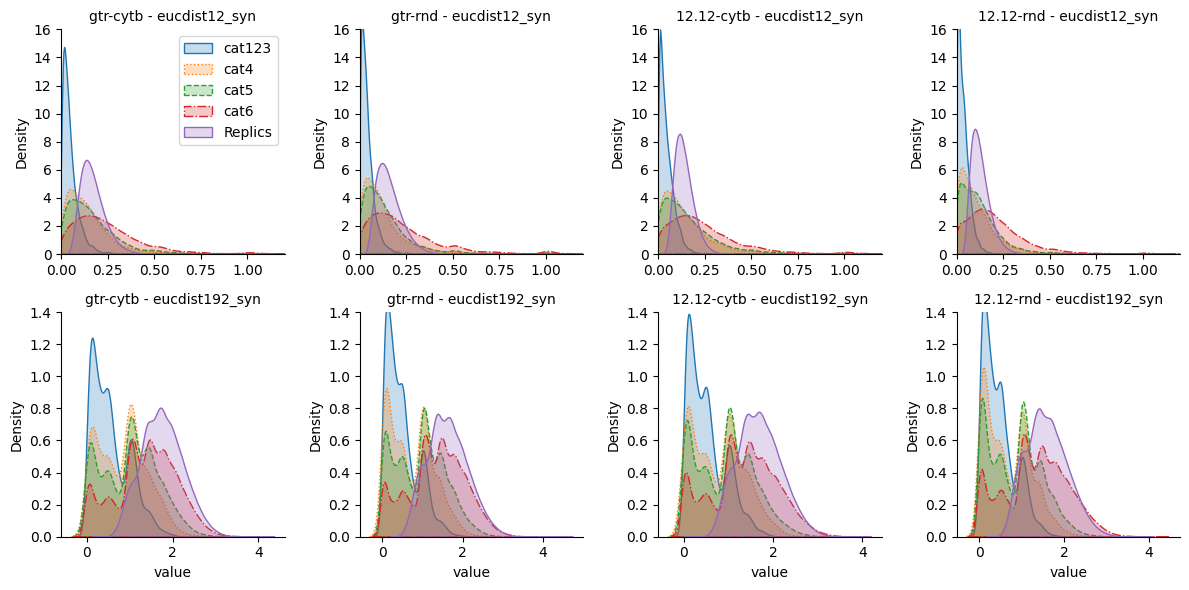

In [23]:
#6min
lss = ['-', ':', '--', '-.', '-']

g = sns.FacetGrid(
    data=_data_to_show, hue="Cat", row="metric", col="cond", 
    # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
    # palette="crest",
    height=3, sharex=False, sharey=False,
    row_order=['eucdist12_syn', 'eucdist192_syn'],
    col_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
    hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
)
g.map(sns.kdeplot, "value", common_norm=False, fill=True)
g.set_titles("{col_name} - {row_name}");
g.axes[0, 0].legend()
handles = g.axes[0, 0].legend_.legendHandles[::-1]
for ls, handle in zip(lss[::-1], handles):
    # print(handle)
    handle.set_ls(ls)

for _cond in g.col_names:
    g.axes_dict[('eucdist12_syn', _cond)].set_xbound(0, 1.2)
    g.axes_dict[('eucdist12_syn', _cond)].set_ybound(0, 16)
    g.axes_dict[('eucdist192_syn', _cond)].set_ybound(0, 1.4)

    for _metric in g.row_names:
        p = g.axes_dict[(_metric, _cond)]
        for line, ls in zip(p.collections, lss):
            line.set_linestyle(ls)

g.savefig("../figures/alisim/eucdist_mam_smooth_syn.png")
plt.show()

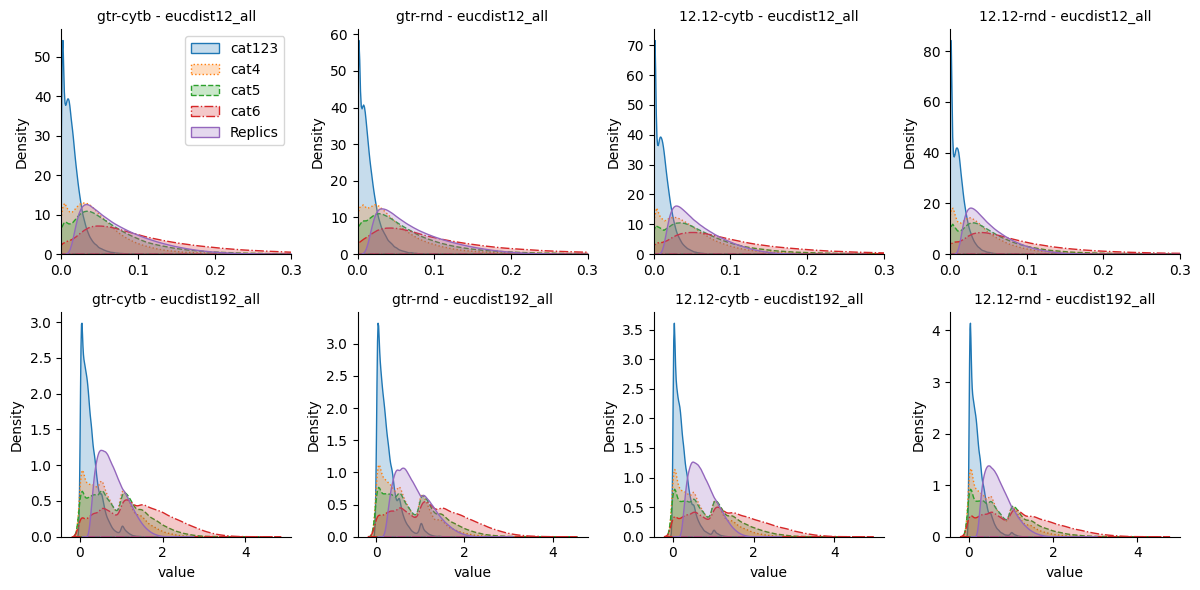

In [24]:
#9min
lss = ['-', ':', '--', '-.', '-']

g = sns.FacetGrid(
    data=_data_to_show, hue="Cat", row="metric", col="cond", 
    # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
    # palette="crest",
    height=3, sharex=False, sharey=False,
    row_order=['eucdist12_all', 'eucdist192_all'],
    col_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
    hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
)
g.map(sns.kdeplot, "value", common_norm=False, fill=True)
g.set_titles("{col_name} - {row_name}");
g.axes[0, 0].legend()
handles = g.axes[0, 0].legend_.legendHandles[::-1]
for ls, handle in zip(lss[::-1], handles):
    # print(handle)
    handle.set_ls(ls)

for _cond in g.col_names:
    g.axes_dict[('eucdist12_all', _cond)].set_xbound(0, 0.3)
    # g.axes_dict[('eucdist192_all', _cond)].set_ybound(0, 1.5)

    for _metric in g.row_names:
        p = g.axes_dict[(_metric, _cond)]
        for line, ls in zip(p.collections, lss):
            line.set_linestyle(ls)

g.savefig("../figures/alisim/eucdist_mam_smooth_all.png")
plt.show()

#### Derive number of data points (edges) around *reference* distribution

In [25]:
rquantiles=replic_vs_replic.groupby(['cond','metric'])['value'].quantile([0.05,0.95]).unstack().reset_index()
rquantiles

,cond,metric,0.05,0.95
0,12.12-cytb,eucdist12_all,0.018745,0.121432
1,12.12-cytb,eucdist12_syn,0.069603,0.232415
2,12.12-cytb,eucdist192_all,0.314504,1.367872
3,12.12-cytb,eucdist192_syn,0.908014,2.539586
4,12.12-rnd,eucdist12_all,0.017123,0.112699
5,12.12-rnd,eucdist12_syn,0.060575,0.227478
6,12.12-rnd,eucdist192_all,0.293792,1.317965
7,12.12-rnd,eucdist192_syn,0.829830,2.447317
8,gtr-cytb,eucdist12_all,0.020717,0.167478
9,gtr-cytb,eucdist12_syn,0.079378,0.296161


In [26]:
cossim2 = cossim.merge(rquantiles, on=['cond', 'metric'])

In [27]:
cossim2['more_than_0.95'] = (cossim2['value'] > cossim2[0.95]).astype(int)
cossim2['less_than_0.05'] = (cossim2['value'] < cossim2[0.05]).astype(int)
cossim2['total'] = (~cossim2['value'].isna()).astype(int)

In [28]:
cossim2.head()

,Cond,Cat,RefNode,AltNode,metric,value,cond,0.05,0.95,more_than_0.95,less_than_0.05,total
0,12.12_mam_cytb_replica_31,cat123,Node100,RN_94,eucdist12_all,0.002727,12.12-cytb,0.018745,0.121432,0,1,1
1,12.12_mam_cytb_replica_31,cat123,Node1003,RN_990,eucdist12_all,0.005451,12.12-cytb,0.018745,0.121432,0,1,1
2,12.12_mam_cytb_replica_31,cat123,Node1004,RN_989,eucdist12_all,0.000133,12.12-cytb,0.018745,0.121432,0,1,1
3,12.12_mam_cytb_replica_31,cat123,Node1006,RN_1000,eucdist12_all,0.000778,12.12-cytb,0.018745,0.121432,0,1,1
4,12.12_mam_cytb_replica_31,cat123,Node1007,RN_999,eucdist12_all,0.001082,12.12-cytb,0.018745,0.121432,0,1,1


In [29]:
cossim2.groupby(['cond', 'metric', 'Cat'])[['more_than_0.95', 'less_than_0.05']].sum()

more_than_0.95  less_than_0.05
cond       metric         Cat                                   
12.12-cytb eucdist12_all  cat123              11          109653
                          cat4              6368           34445
                          cat5             21368           36431
                          cat6             81745           23788
           eucdist12_syn  cat123              38            6951
...                                          ...             ...
gtr-rnd    eucdist192_all cat6             87246           32391
           eucdist192_syn cat123               0            5458
                          cat4                 0            1832
                          cat5                77            7715
                          cat6              2135           11652

[64 rows x 2 columns]

In [30]:
test = cossim2.groupby(['cond', 'Cat', 'metric'])[['more_than_0.95', 'less_than_0.05', 'total']].sum()
test['more_than_0.95'] /= test['total']
test['less_than_0.05'] /= test['total']

In [31]:
a = (test['more_than_0.95'].unstack()).round(4)
a.to_csv("../data/share/alisim_eucdist_mam_more_than_95percentile.csv", float_format="%g")
a

metric             eucdist12_all  eucdist12_syn  eucdist192_all  \
cond       Cat                                                    
12.12-cytb cat123         0.0001         0.0043          0.0015   
           cat4           0.0515         0.1809          0.1318   
           cat5           0.1140         0.2384          0.2327   
           cat6           0.2984         0.4250          0.4616   
12.12-rnd  cat123         0.0001         0.0009          0.0015   
           cat4           0.0483         0.1081          0.1090   
           cat5           0.0965         0.1275          0.1998   
           cat6           0.2661         0.3592          0.4179   
gtr-cytb   cat123         0.0000         0.0040          0.0014   
           cat4           0.0142         0.0840          0.1205   
           cat5           0.0461         0.1370          0.2212   
           cat6           0.1862         0.3017          0.4587   
gtr-rnd    cat123         0.0001         0.0017          0.0005   
           cat4           0.0249         0.0863          0.0560   
           cat5           0.0560         0.1026          0.1260   
           cat6           0.1881         0.2852          0.3312   

metric             eucdist192_syn  
cond       Cat                     
12.12-cytb cat123          0.0000  
           cat4            0.0004  
           cat5            0.0050  
           cat6            0.0449  
12.12-rnd  cat123          0.0000  
           cat4            0.0008  
           cat5            0.0037  
           cat6            0.0662  
gtr-cytb   cat123          0.0000  
           cat4            0.0005  
           cat5            0.0040  
           cat6            0.0291  
gtr-rnd    cat123          0.0000  
           cat4            0.0000  
           cat5            0.0041  
           cat6            0.0415

In [32]:
a = (test['less_than_0.05'].unstack()).round(4)
a.to_csv("../data/share/alisim_eucdist_mam_less_than_5percentile.csv", float_format="%g")
a

metric             eucdist12_all  eucdist12_syn  eucdist192_all  \
cond       Cat                                                    
12.12-cytb cat123         0.7762         0.7923          0.7445   
           cat4           0.2786         0.3392          0.3204   
           cat5           0.1943         0.2931          0.2419   
           cat6           0.0868         0.1501          0.1205   
12.12-rnd  cat123         0.7848         0.8185          0.7625   
           cat4           0.2941         0.3985          0.3482   
           cat5           0.2068         0.3199          0.2620   
           cat6           0.0983         0.1480          0.1358   
gtr-cytb   cat123         0.7801         0.8290          0.7193   
           cat4           0.2640         0.3633          0.2822   
           cat5           0.1865         0.2993          0.2078   
           cat6           0.0805         0.1608          0.0984   
gtr-rnd    cat123         0.7738         0.8297          0.7202   
           cat4           0.2945         0.3902          0.3276   
           cat5           0.2108         0.3264          0.2433   
           cat6           0.0993         0.1642          0.1230   

metric             eucdist192_syn  
cond       Cat                     
12.12-cytb cat123          0.7857  
           cat4            0.5121  
           cat5            0.4259  
           cat6            0.2452  
12.12-rnd  cat123          0.8183  
           cat4            0.5854  
           cat5            0.4672  
           cat6            0.2500  
gtr-cytb   cat123          0.7738  
           cat4            0.5042  
           cat5            0.3990  
           cat6            0.2280  
gtr-rnd    cat123          0.7959  
           cat4            0.5395  
           cat5            0.4155  
           cat6            0.2267

In [33]:
# MEDIAN
cossim.groupby(["cond", "Cat", "metric"]).value.mean().unstack().round(2)

metric             eucdist12_all  eucdist12_syn  eucdist192_all  \
cond       Cat                                                    
12.12-cytb cat123           0.01           0.04            0.23   
           cat4             0.05           0.14            0.69   
           cat5             0.06           0.17            0.88   
           cat6             0.10           0.24            1.35   
12.12-rnd  cat123           0.01           0.04            0.20   
           cat4             0.04           0.11            0.62   
           cat5             0.05           0.12            0.79   
           cat6             0.09           0.21            1.22   
gtr-cytb   cat123           0.01           0.05            0.25   
           cat4             0.05           0.14            0.73   
           cat5             0.06           0.17            0.92   
           cat6             0.10           0.24            1.38   
gtr-rnd    cat123           0.01           0.04            0.25   
           cat4             0.05           0.12            0.66   
           cat5             0.06           0.14            0.84   
           cat6             0.10           0.24            1.26   

metric             eucdist192_syn  
cond       Cat                     
12.12-cytb cat123            0.51  
           cat4              0.79  
           cat5              0.94  
           cat6              1.34  
12.12-rnd  cat123            0.46  
           cat4              0.68  
           cat5              0.86  
           cat6              1.33  
gtr-cytb   cat123            0.55  
           cat4              0.84  
           cat5              1.02  
           cat6              1.38  
gtr-rnd    cat123            0.48  
           cat4              0.73  
           cat5              0.95  
           cat6              1.35

In [34]:
cossim.groupby(["cond", "metric", "Cat"]).value.describe()\
    .rename_axis(index={"cond": "condition", "Cat": "category"})\
        .to_csv("../data/share/alisim_eucdist_mam.csv", float_format="%g")

### Correlate edge cossim versus length

In [99]:
from ete3 import PhyloTree

path_to_tree = "../data/alisim/generations_mam/gtr_mam_cytb_replica_1.full.treefile"
tree = PhyloTree(path_to_tree, format=1)

edges = []
for i, node in enumerate(tree.iter_descendants()):
    # print(node.name, node.up.name, node.dist, )
    closest_leaf, d_to_leaf = node.up.get_closest_leaf()
    edges.append([
        node.up.name, 
        node.name, 
        node.dist, 
        closest_leaf.name, 
        d_to_leaf,
    ])
    # if i == 10:
    #     break

edges_df = pd.DataFrame(edges, columns=["RefNode", "AltNode", "d", "closest_leaf", "d_to_leaf"])
edges_df

,RefNode,AltNode,d,closest_leaf,d_to_leaf
0,ROOT,OUTGRP,1.50000,OUTGRP,1.50000
1,ROOT,Node4705,0.01000,OUTGRP,1.50000
2,Node4705,Node2,1.35799,gerbillus_occiduus,2.02331
3,Node4705,Node4,0.60502,gerbillus_occiduus,2.02331
4,Node2,Node3,0.54029,tachyglossus_aculeatus,0.66537
...,...,...,...,...,...
9405,Node1833,artibeus_planirostris_grenadensis,0.00338,artibeus_planirostris_fallax,0.00338
9406,Node3018,peromyscus_polionotus_peninsularis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9407,Node3018,peromyscus_polionotus_trissyllepsis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9408,Node3019,peromyscus_polionotus_ammobates,0.00092,peromyscus_polionotus_ammobates,0.00092


In [103]:
# cossim = 
pd.concat(raw_data).merge(edges_df[["AltNode", "d", "d_to_leaf"]], on="AltNode").corr("spearman")

,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn,d,d_to_leaf
cossim12_all,1.000000,0.540121,0.671038,0.475829,-0.016756,-0.426740
cossim12_syn,0.540121,1.000000,0.534482,0.656736,-0.308253,-0.456969
cossim192_all,0.671038,0.534482,1.000000,0.659227,-0.267922,-0.625622
cossim192_syn,0.475829,0.656736,0.659227,1.000000,-0.407494,-0.562619
d,-0.016756,-0.308253,-0.267922,-0.407494,1.000000,0.638205
d_to_leaf,-0.426740,-0.456969,-0.625622,-0.562619,0.638205,1.000000


### derive entropy of anc states

In [ ]:
accuracy  = []

colnames = ['Node', 'Site', 'State', 'p_A', 'p_C', 'p_G', 'p_T']
dtypes = {
    'Site': np.int32,
    'p_A': np.float32,
    'p_C': np.float32,
    'p_G': np.float32,
    'p_T': np.float32,
}
i = 0
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec_states = os.path.join(d, "IQTREE/iqtree_anc.state")
    path_to_rec_rates = os.path.join(d, "IQTREE/anc.rate")
    path_to_gt_states  = f"../data/alisim/generations_mam/{cond}.fa"


    if os.path.exists(path_to_gt_states) and os.path.exists(path_to_rec_states):
        rec = pd.read_csv(path_to_rec_states, sep="\t", usecols=colnames, dtype=dtypes, index_col=[0,1])
        rate = pd.read_csv(path_to_rec_rates, sep='\t', comment="#", index_col=0)
        rec = rec.merge(rate[["Cat"]], right_index=True, left_index=True)
        aln = SeqIO.parse(path_to_gt_states, "fasta")
        gt_data = []
        for seq in aln:
            node = seq.id
            if node.startswith("Node"):
                one = pd.DataFrame({
                    "Node":[node for _ in range(len(seq))], 
                    "Site":np.arange(1, len(seq)+1), 
                    "StateGt": list(seq.seq)})
                gt_data.append(one)
        gt = pd.concat(gt_data, ignore_index=True)
        # del gt_data
        df = rec.merge(gt, right_on=["Node", "Site"], left_index=True)
        # acc = (df.State == df.StateGt).sum() / len(df)
        df["is_eq"] = (df.State == df.StateGt).astype(np.int8)
        acc = df.groupby(["Node", "Cat"]).is_eq.value_counts(normalize=True).unstack()[1].rename("Acc").reset_index().assign(Cond=cond)
        accuracy.append(acc)
        # if acc < 0.9:
        #     print(f"WARNING! low accuracy: {acc:.3f} in {cond}")

    # if i == 6:
    #     break

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [34:53<00:00, 10.47s/it]


In [ ]:
df = pd.concat(accuracy)
print(df.shape)
df.head()

(6538560, 4)


,Node,Cat,Acc,Cond
0,Node10,0,1.000000,gtr_mam_cytb_replica_18
1,Node10,1,1.000000,gtr_mam_cytb_replica_18
2,Node10,2,0.995000,gtr_mam_cytb_replica_18
3,Node10,3,0.972067,gtr_mam_cytb_replica_18
4,Node10,4,0.924051,gtr_mam_cytb_replica_18


In [ ]:
df[df.Cat == 7].Cond.value_counts()

12.12_mam_cytb_replica_17    4704
gtr_mam_cytb_replica_45      4704
gtr_mam_cytb_replica_27      4704
Name: Cond, dtype: int64

In [ ]:
df.groupby(["Cond", "Cat"]).Acc.describe().round(2)

count  mean   std   min   25%   50%   75%  max
Cond                     Cat                                                 
12.12_mam_cytb_replica_0 0    4704.0  1.00  0.00  1.00  1.00  1.00  1.00  1.0
                         1    4704.0  1.00  0.00  0.76  1.00  1.00  1.00  1.0
                         2    4704.0  1.00  0.01  0.47  1.00  1.00  1.00  1.0
                         3    4704.0  0.99  0.02  0.39  0.99  1.00  1.00  1.0
                         4    4704.0  0.98  0.03  0.33  0.98  1.00  1.00  1.0
...                              ...   ...   ...   ...   ...   ...   ...  ...
gtr_mam_rnd_replica_9    2    4704.0  0.99  0.02  0.64  0.99  1.00  1.00  1.0
                         3    4704.0  0.98  0.03  0.64  0.98  1.00  1.00  1.0
                         4    4704.0  0.96  0.06  0.52  0.96  0.99  1.00  1.0
                         5    4704.0  0.93  0.08  0.45  0.90  0.97  0.99  1.0
                         6    4704.0  0.86  0.13  0.43  0.77  0.90  0.97  1.0

[1390 rows x 8 columns]

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

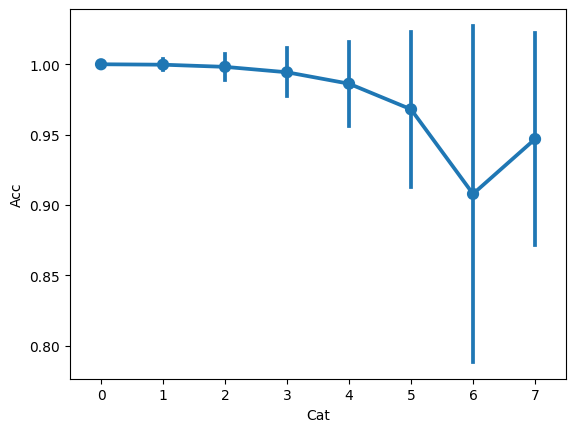

In [ ]:
sns.pointplot(data=df, x="Cat", y="Acc", ci="sd", )

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

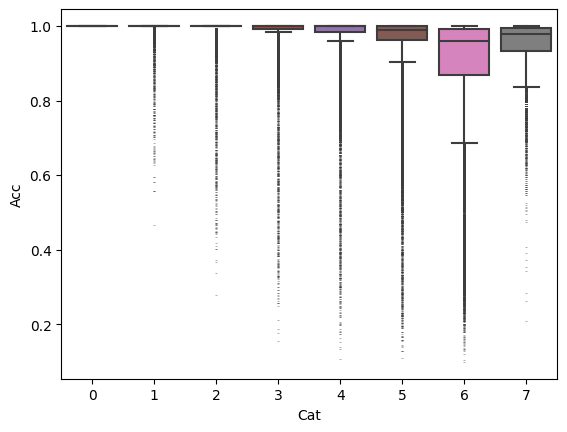

In [ ]:
# plt.figure(figsize=(18, 6))
sns.boxplot(data=df, y="Acc", x="Cat", fliersize=0.1)

### IoU for reconstructed mutations

In [160]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "AltNode"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def obs_iou(cond, pcutoff=0.3, cat_cutoff=4,  only_raw=False):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"

    if os.path.exists(path_to_mapping) and os.path.exists(path_to_rec_obs) and os.path.exists(path_to_gt_obs):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        # rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        # gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        obs_total = pd.merge(rec_obs, gt_obs, "outer", ["AltNode", "PosInGene", "Mut"], suffixes=["_rec", "_gt"])
        obs_total  = obs_total.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        if only_raw:
            # return rec_obs, gt_obs
            return obs_total

        #prepare OBS
        rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
        rec_obs_syn = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 1) & (rec_obs.Cat >= cat_cutoff)]
        gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)
        gt_obs_syn = gt_obs[(gt_obs.Label >= 1) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

        if only_raw:
            return rec_obs_all, gt_obs_all, rec_obs_syn, gt_obs_syn




In [167]:
one = obs_iou(samples[0], 0.3, 4, True)
one.head()

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1


In [169]:
one["IsRec"] = (~one.Label_rec.isna()).astype(np.int8)
one["IsGt"] = (~one.Label_gt.isna()).astype(np.int8)
one["InterCat"] = one.IsRec + one.IsGt * 2 + (one.IsRec == one.IsGt).astype(np.int8)

one["Label"] = np.where(one.Label_gt.isna(), one.Label_rec, one.Label_gt)

In [187]:
one

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1,1,0,1,0.0
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1,1,1,4,0.0
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1,1,0,1,0.0
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1,1,0,1,0.0
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1,1,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0
746340,T[T>G]T,2.0,0.989169,RN_3932,2.0,363,1,1,1,4,2.0


In [242]:
x = one[one.ProbaFull > 0.3].groupby(["InterCat", "Cat"]).ProbaFull.sum().unstack()
x.T / x.sum(axis=1)

InterCat,1,4
Cat,,
1,0.013750,0.042824
2,0.048164,0.109730
3,0.097808,0.157495
4,0.154162,0.196504
5,0.294371,0.260643
6,0.391744,0.232805


In [232]:
sns.boxplot(data=one[one.ProbaFull > 0.3], )

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
6,A[A>T]C,0.0,0.581261,Node1165,0.0,5,1,1,1,4,0.0
7,A[A>C]C,0.0,0.878062,RN_34,0.0,5,1,1,1,4,0.0
8,A[A>C]C,0.0,0.850641,RN_2346,0.0,5,1,1,1,4,0.0
9,A[A>T]C,0.0,0.862363,Node2431,0.0,5,1,1,1,4,0.0
11,C[A>C]C,0.0,0.557711,Node720,0.0,5,1,1,1,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746334,T[T>G]G,2.0,0.915844,RN_1510,2.0,363,1,1,1,4,2.0
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0


In [188]:
one.groupby(["InterCat"]).ProbaFull.agg(["mean", "std"])

,mean,std
InterCat,,
1,0.207197,0.204349
2,NaN,NaN
4,0.743699,0.296585


In [202]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Cat.value_counts(normalize=True).unstack()

Cat,1,2,3,4,5,6
InterCat,,,,,,
1,0.013303,0.047734,0.099258,0.153991,0.299345,0.386369
4,0.040927,0.105913,0.154803,0.194278,0.264347,0.239732


In [203]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Label.value_counts(normalize=True).unstack()

Label,-3.0,-2.0,-1.0,0.0,1.0,2.0
InterCat,,,,,,
1,0.002926,0.067753,0.049719,0.725405,0.018434,0.135764
4,0.002219,0.055087,0.056756,0.728837,0.017534,0.139568


In [222]:
x = one[(one.ProbaFull > 0.3) & (one.Label >= 0)].groupby(["InterCat", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0)
x

Mut               A[A>C]A      A[A>C]C     A[A>C]G      A[A>C]T     A[A>G]A  \
InterCat Cat                                                                  
1        1      10.725331    10.123587    7.745973     4.529652    0.000000   
         2      86.949525    48.281531   30.919084    77.970676    7.287244   
         3     240.104565   129.000467   51.475055   107.849776   13.922884   
         4     349.810507   267.301232   63.949026   294.959874   12.798143   
         5     782.202447   581.153185  169.864017   467.577893   63.778130   
         6     853.306741   642.453622  162.370818   960.129651   94.071558   
4        1     129.023875    84.890575   66.035865   140.538412    4.307356   
         2     488.159635   326.745419  323.540156   489.445966   29.160167   
         3    1060.770745   612.516987  245.783789   540.033418   65.941941   
         4    1271.415642   956.859951  267.086788  1157.216022   71.405220   
         5    1864.059441  1622.618202  465.711891  1180.767434  127.694452   
         6    1343.955930  1147.709999  336.864856  1726.784915  106.529666   

Mut              A[A>G]C    A[A>G]G     A[A>G]T     A[A>T]A     A[A>T]C  ...  \
InterCat Cat                                                             ...   
1        1      0.000000   0.000000    1.495397    0.000000    0.000000  ...   
         2      5.169752   2.432227    4.235381    6.855590    8.684712  ...   
         3      7.002979   3.648313   12.657586   12.941848    5.901379  ...   
         4     19.480278   3.203167   29.796193   12.798126   12.142681  ...   
         5     64.843410  17.422728   52.560583   45.102130   32.948398  ...   
         6     87.866636  16.575756  142.744311   63.954649   59.651707  ...   
4        1      6.865741   4.764203   14.076288   12.772349    5.876642  ...   
         2     22.803544  20.844810   38.514465   51.301575   31.826132  ...   
         3     62.825105  12.810498   51.865300  104.525383   73.874850  ...   
         4     87.161018  17.179426  150.390609  151.389420  121.180504  ...   
         5    216.001797  38.051426  139.458183  200.858506  198.306129  ...   
         6    180.446441  45.696128  246.518653  166.474368  190.933621  ...   

Mut             T[T>A]G     T[T>A]T    T[T>C]A    T[T>C]C    T[T>C]G  \
InterCat Cat                                                           
1        1     1.824435    1.323786   1.724999   1.030638   0.000000   
         2     0.000000    3.048897   0.656403   1.222768   1.082343   
         3     3.364221    8.883802   1.405665   2.485193   3.315102   
         4     0.685581    3.949777   1.154909   2.291266   0.000000   
         5     7.285596   48.685714  16.491727   6.319741   3.104773   
         6     3.372236   12.882050   9.085819   4.057254   1.661541   
4        1    27.243095   74.679837  22.706930  13.733359   6.525567   
         2    13.327726   57.377170  36.872155  33.093445  24.132052   
         3    28.854624   93.249644  37.772399  24.547867  36.213713   
         4    14.954480   42.907610  22.898855  27.777351  11.361344   
         5    22.196587  264.249108  85.856335  59.892314  15.213599   
         6    16.318743   45.072253  43.195579  44.959188  10.727847   

Mut             T[T>C]T     T[T>G]A     T[T>G]C     T[T>G]G     T[T>G]T  
InterCat Cat                                                             
1        1     2.341077    8.551888    3.977213    3.274203    2.954896  
         2     0.749790   17.234164   11.921349    5.370280    5.463112  
         3     3.711440   17.918198   13.855264   13.237436   17.751521  
         4     1.109830   12.996621   15.530819    2.880863   10.381586  
         5    12.542178   74.595763   58.367914   12.189235   74.927133  
         6     3.578148   48.396684   27.720925   15.335823   16.894967  
4        1    30.028026   90.863551   68.290837   62.262258  101.421164  
         2    14.513016  180.334703  158.718612  100.741964   86.051588  
         3    35.187049

<AxesSubplot:xlabel='InterCat-Cat', ylabel='InterCat-Cat'>

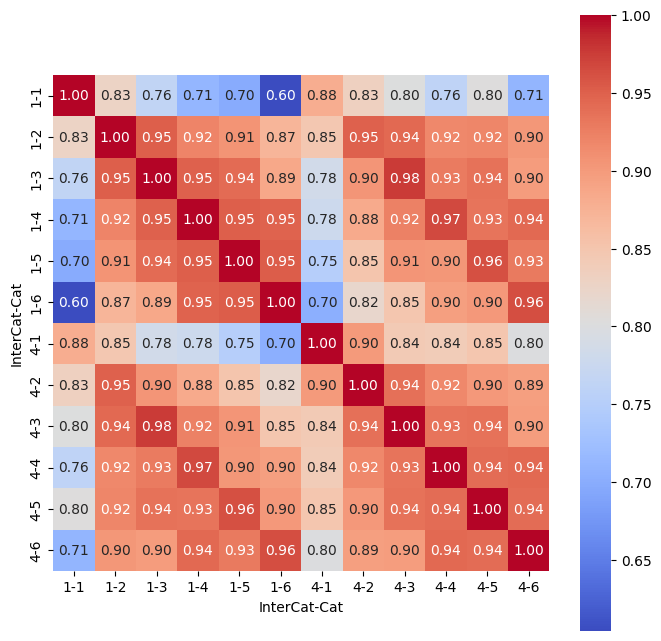

In [223]:
plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(1-squareform(pdist(x, "cosine")), columns=x.index, index=x.index), cmap="coolwarm", annot=True, fmt=".2f", square=True)